<a href="https://colab.research.google.com/github/bkp5190/FoodImageRecognition/blob/main/ImageRecoginiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tensorflow import and version check
# pip install tensorflow
import tensorflow as tf
print(f"Tensorflow Version {tf.__version__}")

Tensorflow Version 2.12.0


In [2]:
# Keras import and numpy/matplotlib
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Install kaggle for dataset
# pip install kaggle

In [4]:
# Upload kaggle.json with API key

# from google.colab import files
# files.upload()
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download Kaggle dataset

# !kaggle datasets download -d kmader/food41
# !unzip food41.zip

<dtype: 'uint8'>


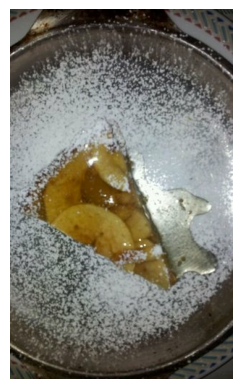

In [5]:
# Read the image file
img = tf.io.read_file('images/apple_pie/1005649.jpg')

# Decode the image
img = tf.image.decode_jpeg(img, channels=3)

# Print the data type of the image
print(img.dtype)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

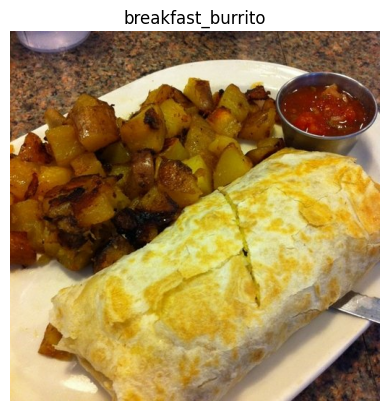

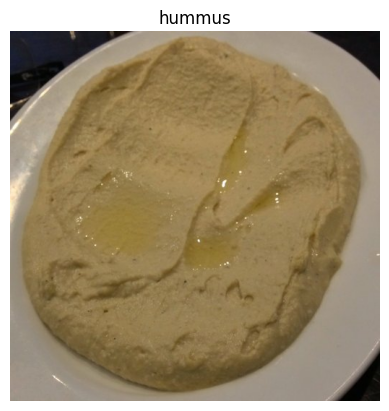

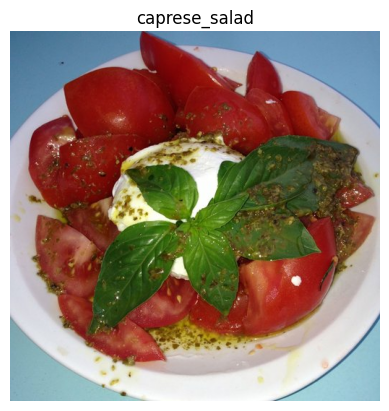

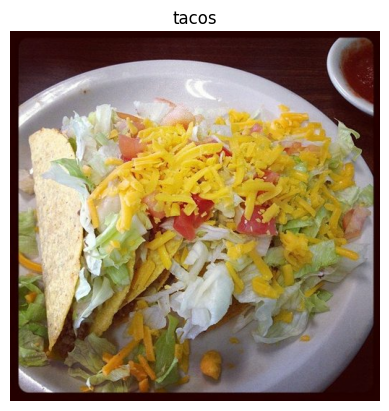

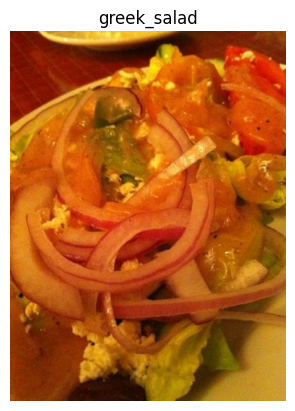

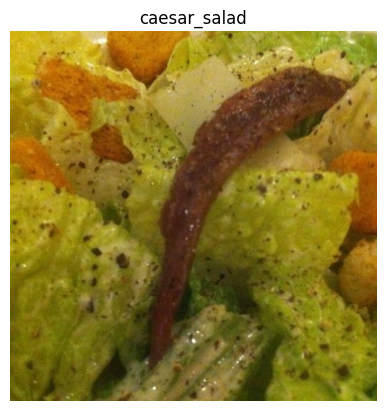

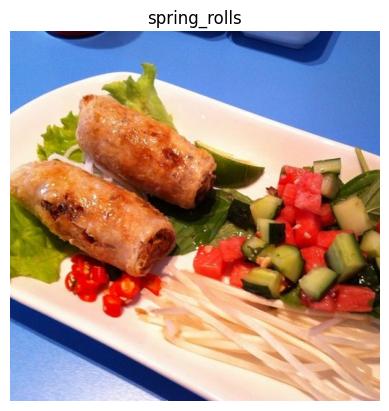

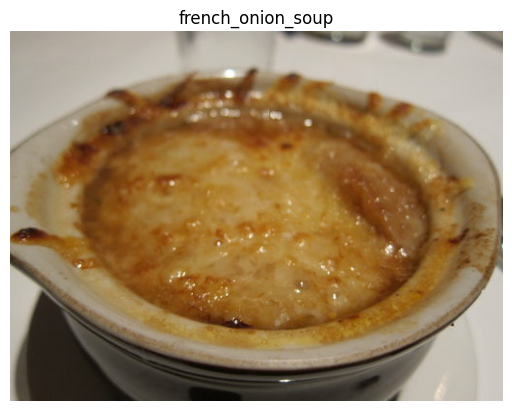

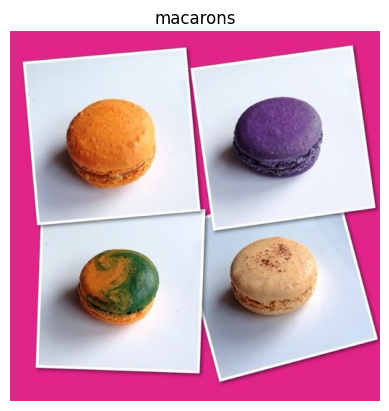

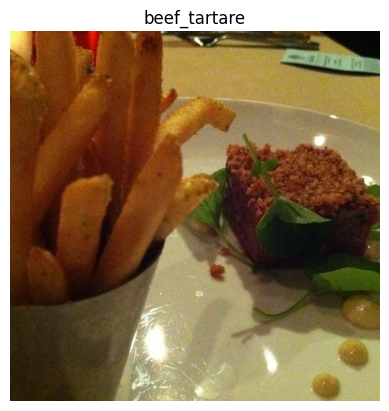

In [6]:
import os

# Define the root directory where the images are located
root_dir = 'images/'

# Get a list of subdirectories (food types)
food_types = os.listdir(root_dir)

# Iterate over the first 10 subdirectories
for food_type in food_types[:10]:
    # Get the list of image files in the current subdirectory
    images_dir = os.path.join(root_dir, food_type)
    image_files = os.listdir(images_dir)

    # Get the path to the first image in the subdirectory
    first_image_path = os.path.join(images_dir, image_files[0])

    # Read and decode the image
    img = tf.io.read_file(first_image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Display the image
    plt.imshow(img)
    plt.title(food_type)
    plt.axis('off')
    plt.show()

In [7]:
# Prepare the Dataset
# Need to iterate over all of the data and label

In [8]:
from sklearn.model_selection import train_test_split

# Read the train.txt and test.txt files
with open('meta/meta/train.txt', 'r') as f:
    train_paths = [line.strip() + '.jpg' for line in f.readlines()]

with open('meta/meta/test.txt', 'r') as f:
    test_paths = [line.strip() + '.jpg' for line in f.readlines()]

# Print the number of training and testing samples
print('Number of training samples:', len(train_paths))
print('Number of testing samples:', len(test_paths))
print('Total', len(train_paths) + len(test_paths))


Number of training samples: 75750
Number of testing samples: 25250
Total 101000


In [11]:
import tensorflow as tf

# Define the directory containing the images
directory = 'images/'

batch_size = 16
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_sou

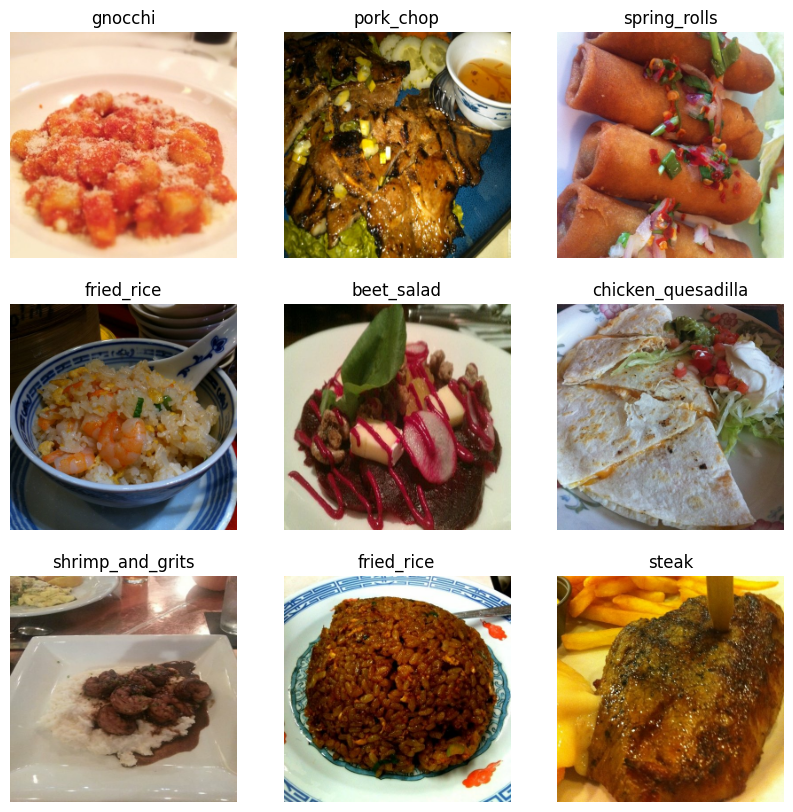

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)


In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [17]:
from tensorflow.keras.models import Sequential
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)